In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import pydrake
import pyro
import torch
print(pyro.__path__)

['/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/pyro']


tensor([0.0262, 1.0040])
['maf$$$arn.layers.1.bias', 'maf$$$arn.layers.0.weight', 'maf$$$arn.layers.2.weight', 'maf$$$arn.layers.0.bias', 'maf$$$arn.layers.1.weight', 'maf$$$arn.layers.2.bias']


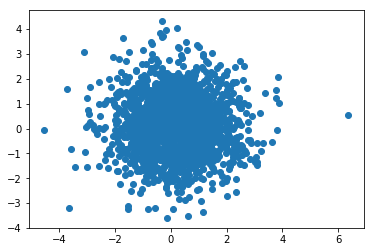

In [2]:
import pyro.distributions as dist
from pyro.nn import AutoRegressiveNN
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
maf = dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [10, 10]))
maf_module = pyro.module("maf", maf)
maf_dist = dist.TransformedDistribution(base_dist, [maf])
print(maf_dist.sample())
ps = pyro.get_param_store()
print(ps.get_all_param_names())
samples = maf_dist.sample(sample_shape=[1000, 2])
plt.scatter(samples[:, 0], samples[:, 1])

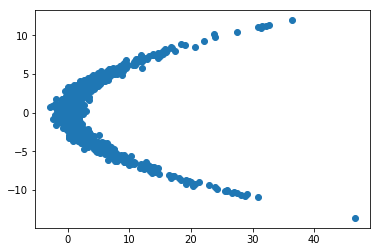

In [41]:
N = 1000

Y = np.random.randn(N)*4
X = np.random.randn(N)*1 + (.25)*Y**2
plt.scatter(X, Y)

In [64]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.contrib.autoguide import AutoDelta
from pyro import poutine

losses = []

data = torch.tensor(np.stack([X, Y]).T, dtype=torch.float)

optimizer = Adam({"lr": 0.01, "betas": (0.90, 0.999)})

base_dist = dist.Normal(torch.zeros(2), torch.ones(2)).to_event(1)
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5])),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5])),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5])),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5]))
]

tf_dist = dist.TransformedDistribution(base_dist, flows)
print(tf_dist.event_shape, tf_dist.batch_shape)
pyro.clear_param_store()

prior_samples = tf_dist.sample(sample_shape=(1000, 2))

def model(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)
    with pyro.plate("data_plate", data.shape[0]):
        pyro.sample("data", tf_dist, obs=data)

def guide(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)

#guide = AutoDelta(poutine.block(model, hide=["obs"]))
print(tf_dist.log_prob(data).shape)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    if (step % 100 == 0):
        print(loss)

torch.Size([2]) torch.Size([])
torch.Size([1000])
90489.6796875
4770.33007812
4548.09228516
4496.35791016
4470.05078125
4447.40039062
4426.54199219
4405.72412109
4382.66015625
4360.40429688


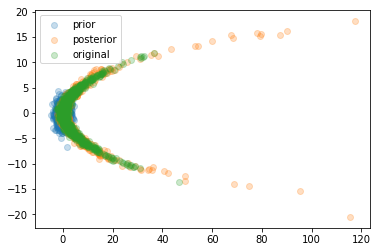

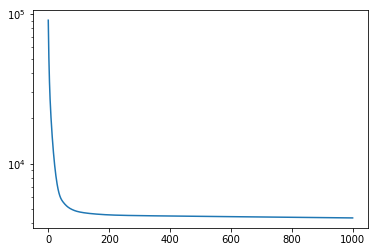

In [65]:
posterior_samples = tf_dist.expand([1000]).sample()
plt.scatter(prior_samples[:, 0], prior_samples[:, 1], label="prior", alpha=0.25)
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.25)
plt.scatter(X, Y, label="original", alpha=0.25)
plt.legend()
plt.figure()
plt.semilogy(losses)

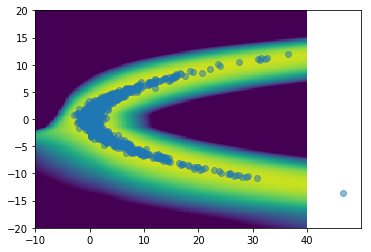

In [66]:
# Draw PDF
x_bounds = [-10., 40.]
y_bounds = [-20., 20.]
n_pts = [200, 200]
Xi, Yi = np.meshgrid(np.linspace(x_bounds[0], x_bounds[1], n_pts[0]),
                   np.linspace(y_bounds[0], y_bounds[1], n_pts[1]),
                   indexing="ij")

logprobs = tf_dist.log_prob(torch.tensor(
    np.vstack([Xi.flatten(), Yi.flatten()]).T, dtype=torch.float))
logprobs = logprobs.detach().numpy().reshape(n_pts).T
    

plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-100, vmax=0)
plt.scatter(X, Y, label="original", alpha=0.5)
#plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.1)

In [67]:
trace = poutine.trace(model).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

               Trace Shapes:         
                Param Sites:         
flow_0$$$arn.layers.0.weight    5 2  
  flow_0$$$arn.layers.0.bias      5  
flow_0$$$arn.layers.1.weight    4 5  
  flow_0$$$arn.layers.1.bias      4  
flow_1$$$arn.layers.0.weight    5 2  
  flow_1$$$arn.layers.0.bias      5  
flow_1$$$arn.layers.1.weight    4 5  
  flow_1$$$arn.layers.1.bias      4  
flow_2$$$arn.layers.0.weight    5 2  
  flow_2$$$arn.layers.0.bias      5  
flow_2$$$arn.layers.1.weight    4 5  
  flow_2$$$arn.layers.1.bias      4  
flow_3$$$arn.layers.0.weight    5 2  
  flow_3$$$arn.layers.0.bias      5  
flow_3$$$arn.layers.1.weight    4 5  
  flow_3$$$arn.layers.1.bias      4  
               Sample Sites:         
             data_plate dist      |  
                       value 1000 |  
                    log_prob      |  
                   data dist 1000 | 2
                       value 1000 | 2
                    log_prob 1000 |  
